In [5]:
!conda install tensorflow numpy keras pandas matplotlib -y --quiet

Solving environment: ...working... done

# All requested packages already installed.



In [6]:
!pip install sklearn

In [1]:
import numpy
import pandas
import sklearn
import tensorflow

In [2]:
# Config gedöns, damit Tensorflow auch die GPU nutzt und wir nicht ewig warten müssen um Ergebnisse zu sehen
from os import cpu_count
num_cores = cpu_count()
config = tensorflow.ConfigProto(intra_op_parallelism_threads=num_cores,
                                     inter_op_parallelism_threads=num_cores,
                                     allow_soft_placement=True,
                                     device_count={'CPU': 1, 'GPU': 1})
config.gpu_options.allow_growth = True
session = tensorflow.Session(config=config)
tensorflow.keras.backend.set_session(session)

In [3]:
# Hier bereiten wir das gesamte MNIST Datenset ein wenig vor, bringen die Bilder in das richtige Format und bereiten die labels one-hot encoded vor.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalizing Data
x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
# convert from int to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
y_train = tensorflow.keras.utils.to_categorical(y_train, 10)
y_test = tensorflow.keras.utils.to_categorical(y_test, 10)
print(f'Shape of split features: {x_train.shape}, \n Shape of split Labels: {y_train.shape}')

11493376/11490434 [==============================] - 4s 0us/step
Shape of split features: (60000, 28, 28, 1), 
 Shape of split Labels: (60000, 10)


In [4]:
# Jetzt teilen wir uns das Datenset in 2 Teile und werfen einen davon weg, um eine geringere Datenmenge zu simulieren. 
# Wir könnten die übrigen daten eigentlich auch zum Validieren nutzen, wenn wir wollen
from sklearn.model_selection import train_test_split

augmented_data_split = 1 - 0.01 # <--- Wer mit der Aufteilung der Datenmengen spielen möchte, verändert einfach diesen wert. Er liegt zwischen 0 und 1 und gibt an, wie viele Daten für unsere Augmentation genutzt werden.

x_train_split, _, y_train_split, _ = train_test_split(x_train, y_train, test_size=augmented_data_split, random_state=42, stratify=y_train)
print(f'Shape of split features: {x_train_split.shape}, \n Shape of split Labels: {y_train_split.shape}')

Shape of split features: (600, 28, 28, 1), 
 Shape of split Labels: (600, 10)


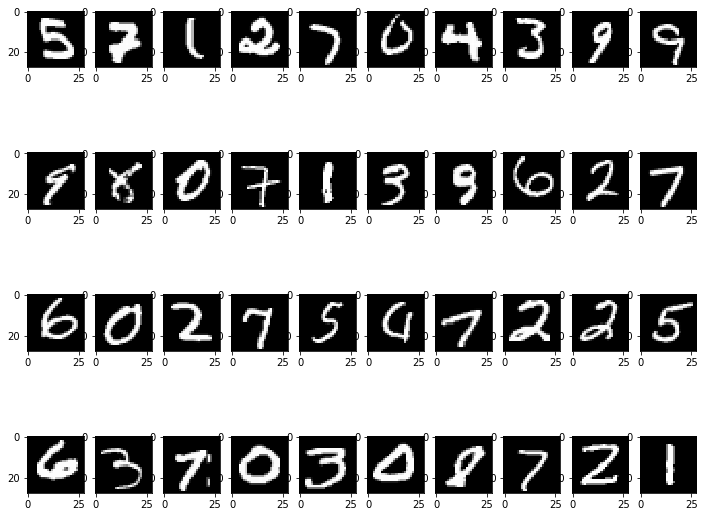

In [5]:
# Informatik soll anschaulich und verständlich sein, also sind hier ein paar unserer Ausgangsbilder aus dem MNIST Datenset
from matplotlib import pyplot
%matplotlib inline
# preview the images first
pyplot.figure(figsize=(12, 10))
x, y = 10, 4
for i in range(40):  
    pyplot.subplot(y, x, i+1)
    pyplot.imshow(x_train_split[i].reshape(28,28), interpolation='nearest', cmap=pyplot.get_cmap('gray'))
pyplot.show()

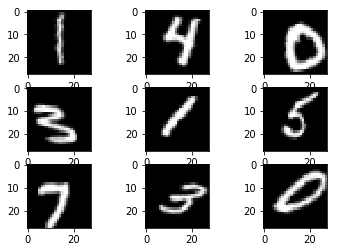

In [6]:
# Als nächstes definieren wir unseren Generator der neuen, künstlichen Daten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Und zeigen natürlich auch eine kleine Auswahl der eben erstellten Bilder
datagen.fit(x_train_split)
for X_batch, y_batch in datagen.flow(x_train_split, y_train_split, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()
    break

In [13]:
# Hier fügen wir jetzt unsere Ausgangsdaten mit den künstlichen Daten zusammen, damit wir gleich viele Bilder wie das originale Datenset nutzen.
nb_aug_images = x_train.shape[0] - x_train_split.shape[0] # <--- Hier berechnen wir, wie viele künstliche Daten wir generieren müssen, um die selbe Datenmenge wie das Originale Datenset zu nutzen.
x_train_aug = numpy.array(x_train_split, copy=True)
y_train_aug = numpy.array(y_train_split, copy=True)

for X_batch, y_batch in datagen.flow(x_train_split, y_train_split, batch_size=nb_aug_images):
    x_train_aug = numpy.vstack((x_train_aug, X_batch))
    y_train_aug = numpy.vstack((y_train_aug, y_batch))
    if x_train_aug.shape[0] == x_train.shape[0]:
        break
print(f'Shape of augmented features: {x_train_aug.shape}, \n Shape of augmented Labels: {y_train_aug.shape}')

Shape of augmented features: (60000, 28, 28, 1), 
 Shape of augmented Labels: (60000, 10)


In [14]:
# Nun erstellen wir uns mal ein schönes 2D-Convolutional Network mit Keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def create_model():
    tensorflow.keras.backend.clear_session()
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.20))
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
                  optimizer=tensorflow.keras.optimizers.RMSprop(),
                  metrics=['accuracy'])
    return model

In [16]:
# Am besten legen wir noch ein paar Callbacks fest, die nach jedem Epoch geprüft werden und eventuell unsere Genauigkeit erhöhen können
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

early_stopping = EarlyStopping(monitor='val_acc',
                              min_delta=0.01, 
                              patience = 5)

In [17]:
# Training mit augmentierten Daten
epochs = 5
batch_size = 32
model_aug = create_model()
history_aug = model_aug.fit(x_train_aug, y_train_aug, batch_size=batch_size, validation_data=(x_test, y_test), epochs=epochs, callbacks=[learning_rate_reduction, early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 117s 2ms/step - loss: 0.1612 - acc: 0.9478 - val_loss: 0.1014 - val_acc: 0.9699
Epoch 2/5
60000/60000 [==============================] - 121s 2ms/step - loss: 0.0195 - acc: 0.9940 - val_loss: 0.1119 - val_acc: 0.9732
Epoch 3/5
60000/60000 [==============================] - 124s 2ms/step - loss: 0.0113 - acc: 0.9963 - val_loss: 0.0945 - val_acc: 0.9818
Epoch 4/5
60000/60000 [==============================] - 123s 2ms/step - loss: 0.0089 - acc: 0.9972 - val_loss: 0.1173 - val_acc: 0.9757
Epoch 5/5
60000/60000 [==============================] - 121s 2ms/step - loss: 0.0072 - acc: 0.9978 - val_loss: 0.0765 - val_acc: 0.9842


In [18]:
# Training mit normalem MNIST
model_norm = create_model()
history_norm = model_norm.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_test, y_test), epochs=epochs, callbacks=[learning_rate_reduction, early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 128s 2ms/step - loss: 0.1358 - acc: 0.9577 - val_loss: 0.0568 - val_acc: 0.9812
Epoch 2/5
60000/60000 [==============================] - 145s 2ms/step - loss: 0.0536 - acc: 0.9833 - val_loss: 0.0229 - val_acc: 0.9923
Epoch 3/5
60000/60000 [==============================] - 171s 3ms/step - loss: 0.0429 - acc: 0.9870 - val_loss: 0.0218 - val_acc: 0.9930
Epoch 4/5
60000/60000 [==============================] - 168s 3ms/step - loss: 0.0372 - acc: 0.9886 - val_loss: 0.0201 - val_acc: 0.9929
Epoch 5/5
60000/60000 [==============================] - 178s 3ms/step - loss: 0.0328 - acc: 0.9903 - val_loss: 0.0223 - val_acc: 0.9924


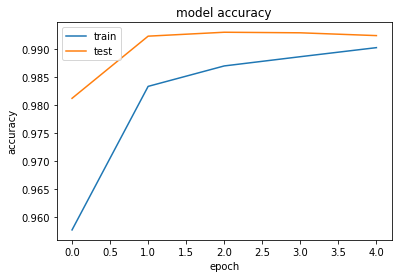

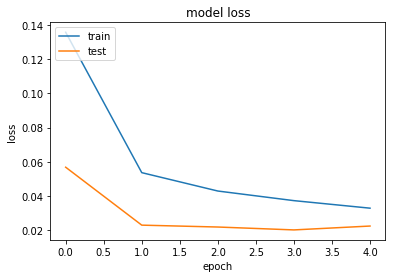

In [19]:
# Jeder liebt graphen, also sehen wir uns noch die Steigung der Genauigkeit und den Fall der Loss Werte an und freuen uns über unsere tollen Ergebnisse. Danke an Jason von machinelearningmastery.com
# summarize history for accuracy
pyplot.plot(history_norm.history['acc'])
pyplot.plot(history_norm.history['val_acc'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history for loss
pyplot.plot(history_norm.history['loss'])
pyplot.plot(history_norm.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

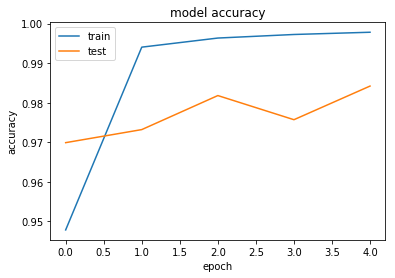

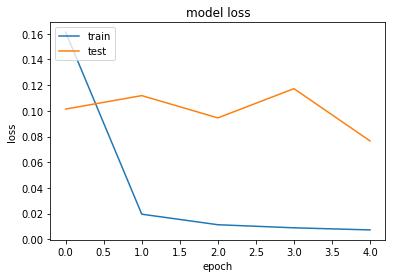

In [20]:
# Natürlich auch für unsere Augmentierten Daten
# summarize history for accuracy
pyplot.plot(history_aug.history['acc'])
pyplot.plot(history_aug.history['val_acc'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history for loss
pyplot.plot(history_aug.history['loss'])
pyplot.plot(history_aug.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()